# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

Open the [Data_Dictionary.md](Data_Dictionary.md)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,GEBURTSJAHR,person,ordinal,[-1]
freq,1,43,49,26


In [7]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
# Use this to look at values in a single column
azdias['KK_KUNDENTYP'].value_counts(dropna=False)

NaN    584612
3.0     65151
2.0     62564
5.0     48038
4.0     44512
6.0     44114
1.0     42230
Name: KK_KUNDENTYP, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

# Some values are numbers, some are strings (XX)
def num(s):
    try:
        return int(s)
    except ValueError:
        return s

# Loop all features and replace values for missing data with NAN
for index, feature in feat_info.iterrows():
    missing = feature['missing_or_unknown']
    attr = feature['attribute']
    if missing == "[]":
        continue
    values = missing[1:-1].split(",")
    # print (attr, missing, values)
    for value in values:
        azdias[attr] = azdias[attr].replace(num(value), np.NAN)
        
azdias.head(10)  

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
    
nan = azdias.isna().sum()
    


In [11]:
# Investigate patterns in the amount of missing data in each column.
nan.head()


AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

<AxesSubplot:>

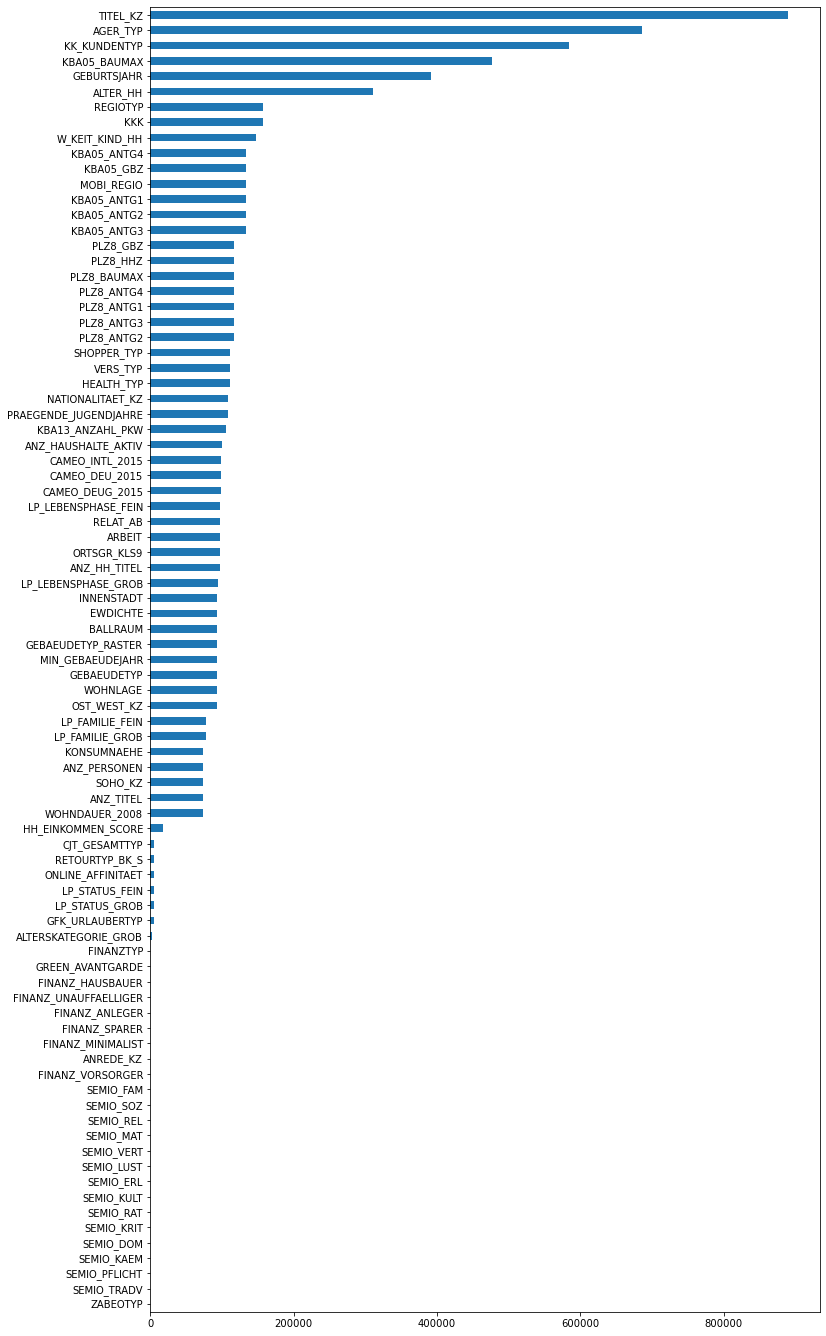

In [12]:
nan.sort_values().plot(kind = "barh", figsize = (12, 24))

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

dropped_columns = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX"]
azdias_cols_dropped = azdias.drop(dropped_columns, axis = 1)
azdias_cols_dropped.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


The `TITEL_KZ` is almost not used, but such titles are rare, so the information could be valuable anyway. I would convert this column to a true/false value, but in this case I just drop it with the other outliers.

The `AGER_TYP` has few values, and they only tell if the person is old or not. Since we have this information in the `ALTERSKATEGORIE_GROB` column, I will drop the `AGER_TYP`.

It is funny that the `KK_KUNDENTYP` column has values for about 1/3 of the general population. How can that be valid for this particular case? I choose to drop it.

The `KBA05_BAUMAX` column seems not to be properly populated, and I believe the information is in the other KBA05-columns, so I drop it.

I will keep the `GEBURTSJAHR` even though it is only 1/2 populated, since I believe it has value, and there is no other attribute covering this properly.

I will also keep the `ALTER_HH` column, as it is populated for 2/3 of the population.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

nan_count = azdias_cols_dropped.isna().sum(axis=1)

<AxesSubplot:>

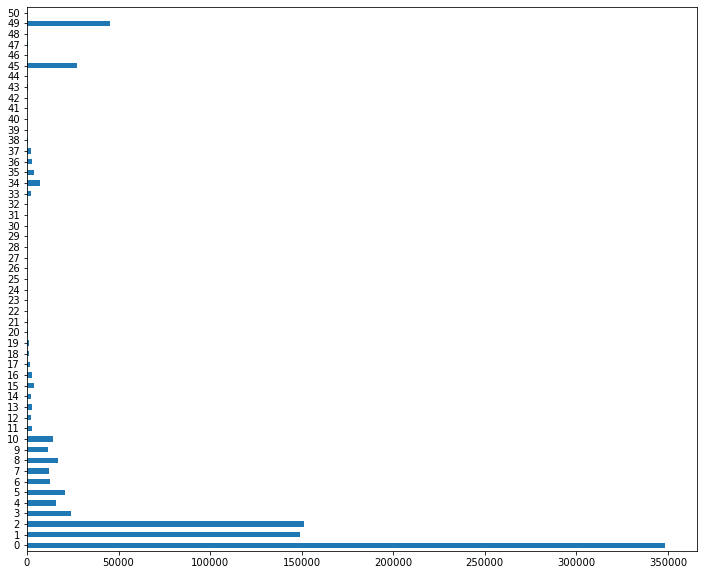

In [15]:
# Show number of rows (x) with how many missing values (y) 
nan_count.value_counts().sort_index().plot(kind = "barh", figsize = (12, 10))

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

max_nan = 2
azdias_rows_less_nan = azdias_cols_dropped[nan_count <= max_nan]
azdias_rows_more_nan = azdias_cols_dropped[nan_count > max_nan]


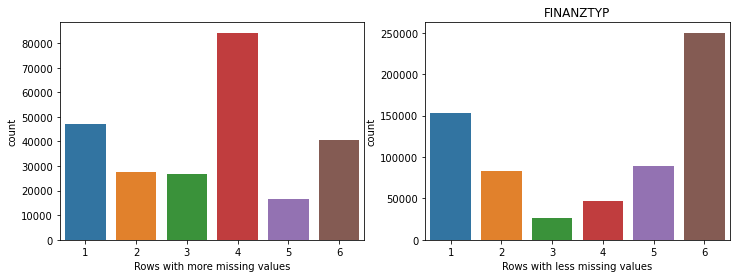

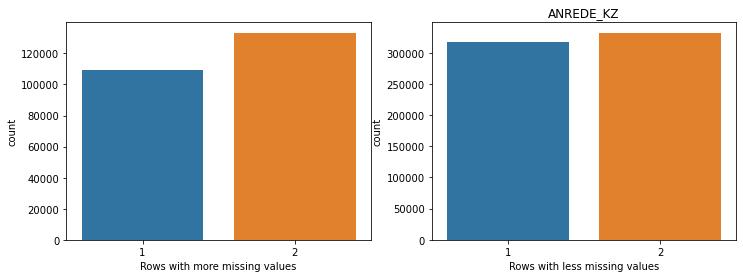

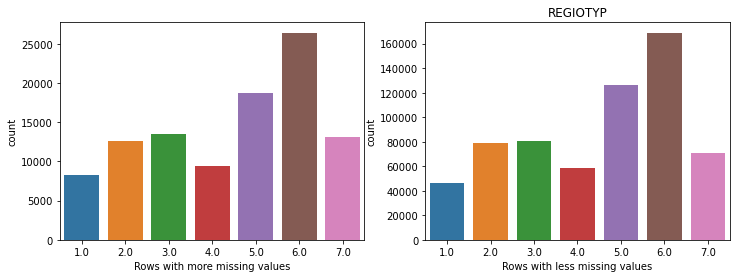

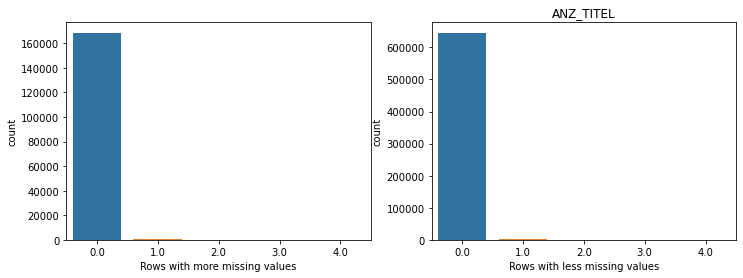

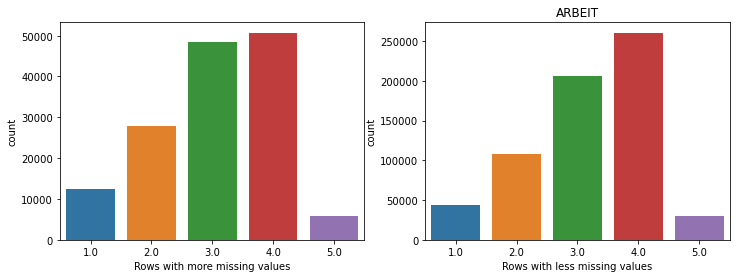

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for cat in ["FINANZTYP", "ANREDE_KZ", "REGIOTYP", "ANZ_TITEL", "ARBEIT"]:
    f, (ax1, ax2) = plt.subplots(1, 2, sharex = True)
    f.set_figwidth(12)
    plt.title(cat)
    
    plt.sca(ax1)
    sns.countplot(x=cat, data=azdias_rows_more_nan)
    ax1.set_xlabel("Rows with more missing values")

    plt.sca(ax2)
    sns.countplot(x=cat, data=azdias_rows_less_nan)
    ax2.set_xlabel("Rows with less missing values")

    plt.show()
    
    

#### Discussion 1.1.3: Assess Missing Data in Each Row


It looks like I can get a lot of data with only 0-2 missing values, so that will make a really good data set. Therefore I will create one data set with those, and another with the rest.

The FINANZTYP data is strange. There is a lot more VORSORGER in the rows with more missing data. Except from that, the distribution is pretty much the same.




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

<AxesSubplot:>

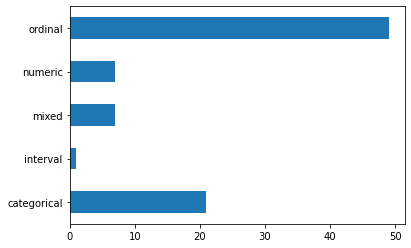

In [18]:
# How many features are there of each data type?

feat_info['type'].value_counts().sort_index().plot(kind = "barh")

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info["type"] == 'categorical']
categorical = categorical[~categorical.attribute.isin(dropped_columns)]

for attr in categorical["attribute"]:
    print(attr)
    print(azdias_rows_less_nan[attr].value_counts())
    print()



ANREDE_KZ
2    332000
1    316422
Name: ANREDE_KZ, dtype: int64

CJT_GESAMTTYP
4.0    166893
3.0    124522
2.0    117048
5.0     83487
6.0     80547
1.0     75925
Name: CJT_GESAMTTYP, dtype: int64

FINANZTYP
6    249966
1    152593
5     89645
2     83204
4     46399
3     26615
Name: FINANZTYP, dtype: int64

GFK_URLAUBERTYP
12.0    101474
10.0     84866
8.0      71316
11.0     62525
5.0      59966
4.0      52589
3.0      45194
9.0      44691
1.0      41957
7.0      32701
2.0      29718
6.0      21425
Name: GFK_URLAUBERTYP, dtype: int64

GREEN_AVANTGARDE
0    497413
1    151009
Name: GREEN_AVANTGARDE, dtype: int64

LP_FAMILIE_FEIN
1.0     335801
10.0    112466
2.0      84083
11.0     43537
8.0      18181
7.0      15374
4.0       9805
5.0       9463
9.0       9295
6.0       6581
3.0       3836
Name: LP_FAMILIE_FEIN, dtype: int64

LP_FAMILIE_GROB
1.0    335801
5.0    165298
2.0     84083
4.0     40136
3.0     23104
Name: LP_FAMILIE_GROB, dtype: int64

LP_STATUS_FEIN
1.0     179160
9.0   

In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode the OST_WEST_KZ to number
azdias_rows_less_nan["OST_WEST_KZ"] = azdias_rows_less_nan["OST_WEST_KZ"].replace(["W", "O"], [1, 0])


<ipython-input-20-694fdf5e8792>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_rows_less_nan["OST_WEST_KZ"] = azdias_rows_less_nan["OST_WEST_KZ"].replace(["W", "O"], [1, 0])


In [21]:
# OneHot encode the rest
columns_to_encode = ["CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015", "CAMEO_DEU_2015"]
one_hot_encoded_data = pd.get_dummies(azdias_rows_less_nan, columns = columns_to_encode)


In [22]:
one_hot_encoded_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,1996.0,0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1979.0,1,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,1963.0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,1943.0,0,...,0,0,0,1,0,0,0,0,0,0
6,2.0,2,1,5,1,5,4,3,NaN,0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features


I kept the binary numeric categories unchanged, and changed the one with non-numeric values to 1 and 0. The other categorical columns I one-hot encoded using pandas.

I choose to keep them all, since I will reduce them later.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
one_hot_encoded_data['PRAEGENDE_JUGENDJAHRE'].value_counts(dropna=False).sort_index()


1.0      16074
2.0       6354
3.0      45936
4.0      18674
5.0      72291
6.0      23164
7.0       3545
8.0     117440
9.0      29663
10.0     71014
11.0     29631
12.0     20611
13.0      4667
14.0    153129
15.0     35311
NaN        918
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [24]:
# Set decade
one_hot_encoded_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = one_hot_encoded_data["PRAEGENDE_JUGENDJAHRE"].replace(range(1, 16), [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90])

In [25]:
# Set movement, 1 for Mainstream, 2 for Avantgarde
one_hot_encoded_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = one_hot_encoded_data["PRAEGENDE_JUGENDJAHRE"].replace(range(1, 16), [1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2])

In [26]:
one_hot_encoded_data.drop("PRAEGENDE_JUGENDJAHRE", axis = 1)
one_hot_encoded_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2,1,5,2,5,4,5,1996.0,0,...,0,0,0,0,0,0,0,0,90.0,1.0
2,3.0,2,1,4,1,2,3,5,1979.0,1,...,0,0,0,0,0,0,0,0,90.0,2.0
4,3.0,1,4,3,4,1,3,2,1963.0,0,...,0,0,0,0,0,0,0,0,70.0,1.0
5,1.0,2,3,1,5,2,2,5,1943.0,0,...,0,1,0,0,0,0,0,0,50.0,1.0
6,2.0,2,1,5,1,5,4,3,NaN,0,...,0,0,0,0,0,0,0,0,80.0,1.0


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
one_hot_encoded_data['CAMEO_INTL_2015'].value_counts(dropna=False).sort_index()


12      9081
13     20977
14     51308
15     14384
22     25724
23     16945
24     76164
25     32560
31     13342
32      8495
33      7848
34     15426
35      8608
41     76773
43     47703
44     12354
45     22590
51    113224
52     17136
54     38629
55     19151
Name: CAMEO_INTL_2015, dtype: int64

In [28]:
one_hot_encoded_data["CAMEO_INTL_2015_WEALTH"] = one_hot_encoded_data["CAMEO_INTL_2015"].astype(int).floordiv(10)
one_hot_encoded_data["CAMEO_INTL_2015_LIFESTAGE"] = one_hot_encoded_data["CAMEO_INTL_2015"].astype(int).mod(10)
one_hot_encoded_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,1996.0,0,...,0,0,0,0,0,0,90.0,1.0,5,1
2,3.0,2,1,4,1,2,3,5,1979.0,1,...,0,0,0,0,0,0,90.0,2.0,2,4
4,3.0,1,4,3,4,1,3,2,1963.0,0,...,0,0,0,0,0,0,70.0,1.0,4,3
5,1.0,2,3,1,5,2,2,5,1943.0,0,...,0,0,0,0,0,0,50.0,1.0,5,4
6,2.0,2,1,5,1,5,4,3,NaN,0,...,0,0,0,0,0,0,80.0,1.0,2,2


In [29]:
# Drop the handled columns
one_hot_encoded_data = one_hot_encoded_data.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis = 1)


In [30]:
# Other mixed columns:
handled_columns = dropped_columns + ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"]
mixed = feat_info[feat_info["type"] == 'mixed']
mixed = mixed[~mixed.attribute.isin(handled_columns)]

for attr in mixed["attribute"]:
    print(attr)
    print(azdias_rows_less_nan[attr].value_counts())
    print()

LP_LEBENSPHASE_FEIN
1.0     53498
5.0     48132
6.0     36391
2.0     33682
8.0     24394
29.0    22890
13.0    22231
7.0     22196
31.0    20586
11.0    19227
30.0    18440
10.0    18413
15.0    17547
12.0    17184
3.0     15808
20.0    15017
19.0    14857
37.0    14602
14.0    14531
4.0     14450
32.0    14144
39.0    13994
40.0    13527
16.0    12268
35.0    11689
38.0    11223
21.0    10814
34.0    10283
9.0     10194
24.0    10007
27.0     9702
28.0     9411
36.0     8774
25.0     8279
23.0     6459
22.0     5831
33.0     5145
18.0     5065
17.0     4798
26.0     2737
Name: LP_LEBENSPHASE_FEIN, dtype: int64

LP_LEBENSPHASE_GROB
2.0     131113
1.0     117438
3.0      87250
12.0     62120
4.0      44346
9.0      41330
5.0      39737
10.0     34730
11.0     27117
6.0      23104
8.0      21850
7.0      18286
Name: LP_LEBENSPHASE_GROB, dtype: int64

WOHNLAGE
3.0    210006
7.0    139572
4.0    112172
2.0     83308
5.0     58823
1.0     37333
8.0      7195
0.0        13
Name: WOHNLAGE, d

#### Discussion 1.2.2: Engineer Mixed-Type Features

I create two new columns for decade and movement, and populate them based on values in PRAEGENDE_JUGENDJAHRE, and then drop the original column.

Since values then are numbers, I just keep them.

For the CAMEO_INTL_2015, I just split the number in the two digits, creating two new numeric columns and dropping the original.

Other mixed columns are kind of scalar, so I keep them as the numerics they are.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

one_hot_encoded_data.dtypes.value_counts()


uint8      128
float64     45
int64       25
dtype: int64

Only numeric columns left.

In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    res = df.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, feature in feat_info.iterrows():
        missing = feature['missing_or_unknown']
        attr = feature['attribute']
        if missing == "[]":
            continue
        values = missing[1:-1].split(",")
        for value in values:
            res[attr] = res[attr].replace(num(value), np.NAN)
    
    
    # remove selected columns and rows, ...
    res = res.drop(dropped_columns, axis = 1)
    
    
    nan_count = res.isna().sum(axis=1)
    max_nan = 2
    res = res[nan_count <= max_nan]
    

    # select, re-encode, and engineer column values.
    res["OST_WEST_KZ"] = res["OST_WEST_KZ"].replace(["W", "O"], [1, 0])
    columns_to_encode = ["CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015", "CAMEO_DEU_2015"]
    res = pd.get_dummies(res, columns = columns_to_encode)
    
    res["PRAEGENDE_JUGENDJAHRE_DECADE"] = res["PRAEGENDE_JUGENDJAHRE"].replace(range(1, 16), [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90])
    res["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = res["PRAEGENDE_JUGENDJAHRE"].replace(range(1, 16), [1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2])
    
    res["CAMEO_INTL_2015_WEALTH"] = res["CAMEO_INTL_2015"].astype(int).floordiv(10)
    res["CAMEO_INTL_2015_LIFESTAGE"] = res["CAMEO_INTL_2015"].astype(int).mod(10)

    res = res.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis = 1)

    
    # Return the cleaned dataframe.
    return res
    

In [34]:
# Try the cleaning function
one_hot_encoded_data = clean_data(azdias)
one_hot_encoded_data.shape

(648422, 198)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

count_na = one_hot_encoded_data.isna().sum().sort_values(ascending = False)
count_na


GEBURTSJAHR                  237734
ALTER_HH                     171197
REGIOTYP                      17211
KKK                           17211
W_KEIT_KIND_HH                 6056
                              ...  
FINANZTYP_6                       0
GFK_URLAUBERTYP_1.0               0
GFK_URLAUBERTYP_2.0               0
GFK_URLAUBERTYP_3.0               0
CAMEO_INTL_2015_LIFESTAGE         0
Length: 198, dtype: int64

In [36]:
one_hot_encoded_data.shape

(648422, 198)

In [37]:
columns_with_few_na = count_na[count_na > 0][count_na < 1000].keys()
columns_with_few_na

Index(['PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE_DECADE',
       'ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ARBEIT', 'RELAT_AB',
       'KONSUMNAEHE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'GEBAEUDETYP_RASTER'],
      dtype='object')

In [38]:
one_hot_encoded_data_dropped = one_hot_encoded_data.dropna(axis = 0, subset = columns_with_few_na)

In [39]:
columns_with_many_na = count_na[count_na >= 1000].keys()
columns_with_many_na

Index(['GEBURTSJAHR', 'ALTER_HH', 'REGIOTYP', 'KKK', 'W_KEIT_KIND_HH'], dtype='object')

In [40]:
# Use Imputer on missing values
imputer = Imputer().fit(one_hot_encoded_data_dropped)
data_with_imputer = imputer.transform(one_hot_encoded_data_dropped)

In [41]:
data_with_imputer

array([[1., 2., 1., ..., 1., 5., 1.],
       [3., 2., 1., ..., 2., 2., 4.],
       [3., 1., 4., ..., 1., 4., 3.],
       ...,
       [2., 2., 1., ..., 1., 3., 1.],
       [1., 1., 1., ..., 1., 5., 1.],
       [4., 1., 4., ..., 1., 4., 3.]])

In [42]:
# Apply feature scaling to the general population demographics data.

scaler = MinMaxScaler().fit(data_with_imputer)
scaled_data = scaler.transform(data_with_imputer)

In [43]:
scaled_data

array([[0.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 1.        , 0.        , ..., 1.        , 0.25      ,
        0.75      ],
       [0.66666667, 0.        , 0.75      , ..., 0.        , 0.75      ,
        0.5       ],
       ...,
       [0.33333333, 1.        , 0.        , ..., 0.        , 0.5       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.75      , ..., 0.        , 0.75      ,
        0.5       ]])

### Discussion 2.1: Apply Feature Scaling

For features missing in less than 1000 rows, I will just drop the rows. For the 5 features missing more data, I will try an imputer.

The suggested scaler, StandardScaler, did not work for me. When I used it, I got all the customers in one cluster. However, by using the MinMaxScaler, I got much better results. I also see that this is used in many examples for PCA. For the StandardScaler to work on PCA, the data should have a normal distribution, but some of these data do not.

So I use the MinMaxScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.


def do_pca(n_components, scaled_data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(scaled_data)
    return pca, X_pca

def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(14, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_title('Explained Variance Per Principal Component')

In [45]:
pca, X_pca = do_pca(198, scaled_data)

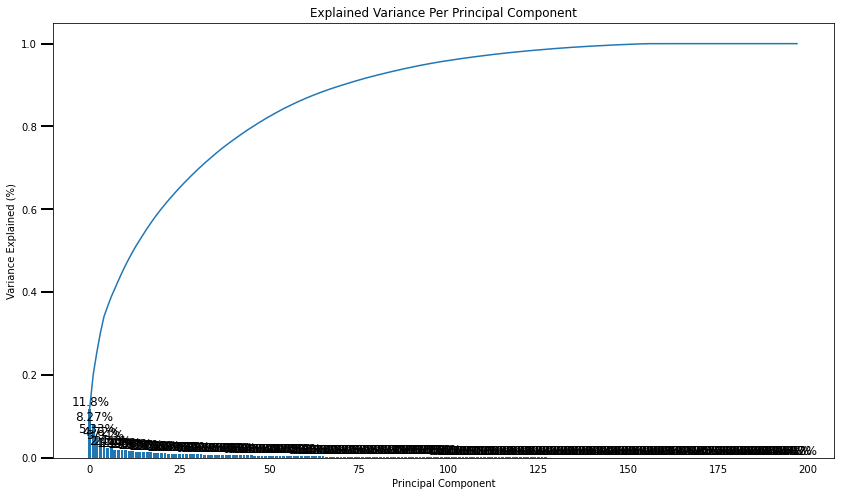

In [46]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)


In [47]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(30)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)



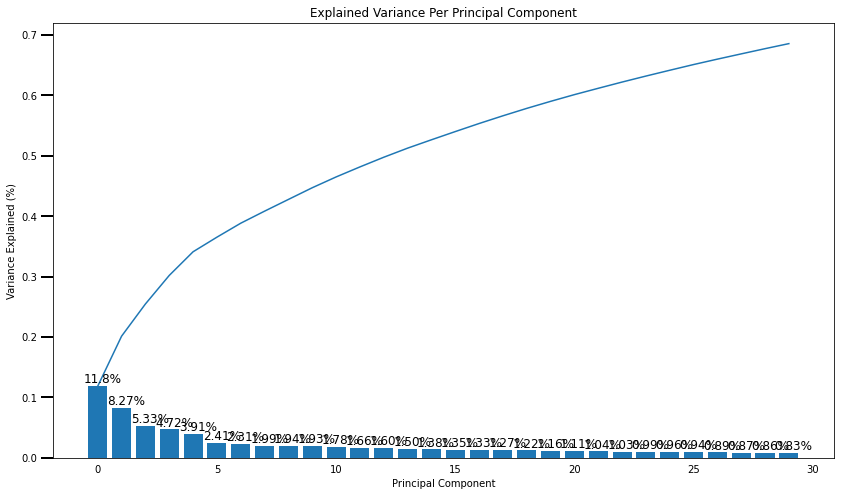

In [48]:
scree_plot(pca)

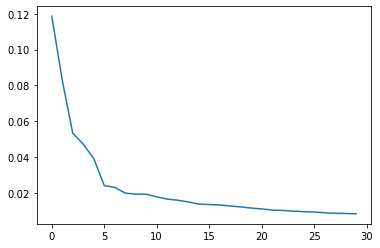

In [49]:
plt.plot(pca.explained_variance_ratio_)

### Discussion 2.2: Perform Dimensionality Reduction


The first scree plot shows that the first 25-30 eigenvectors give value, but that after that, the value is being reduced.
I therefore choose to continue with 30 vectors.

If I should want to reduce the number of components, even the 5 first vectores give a lot of value here.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def show_component(component, pca, dataset):
    ser = pd.Series(pca.components_[component], dataset.columns)
    ser.sort_values().plot(kind = "barh", figsize = (12, 50))



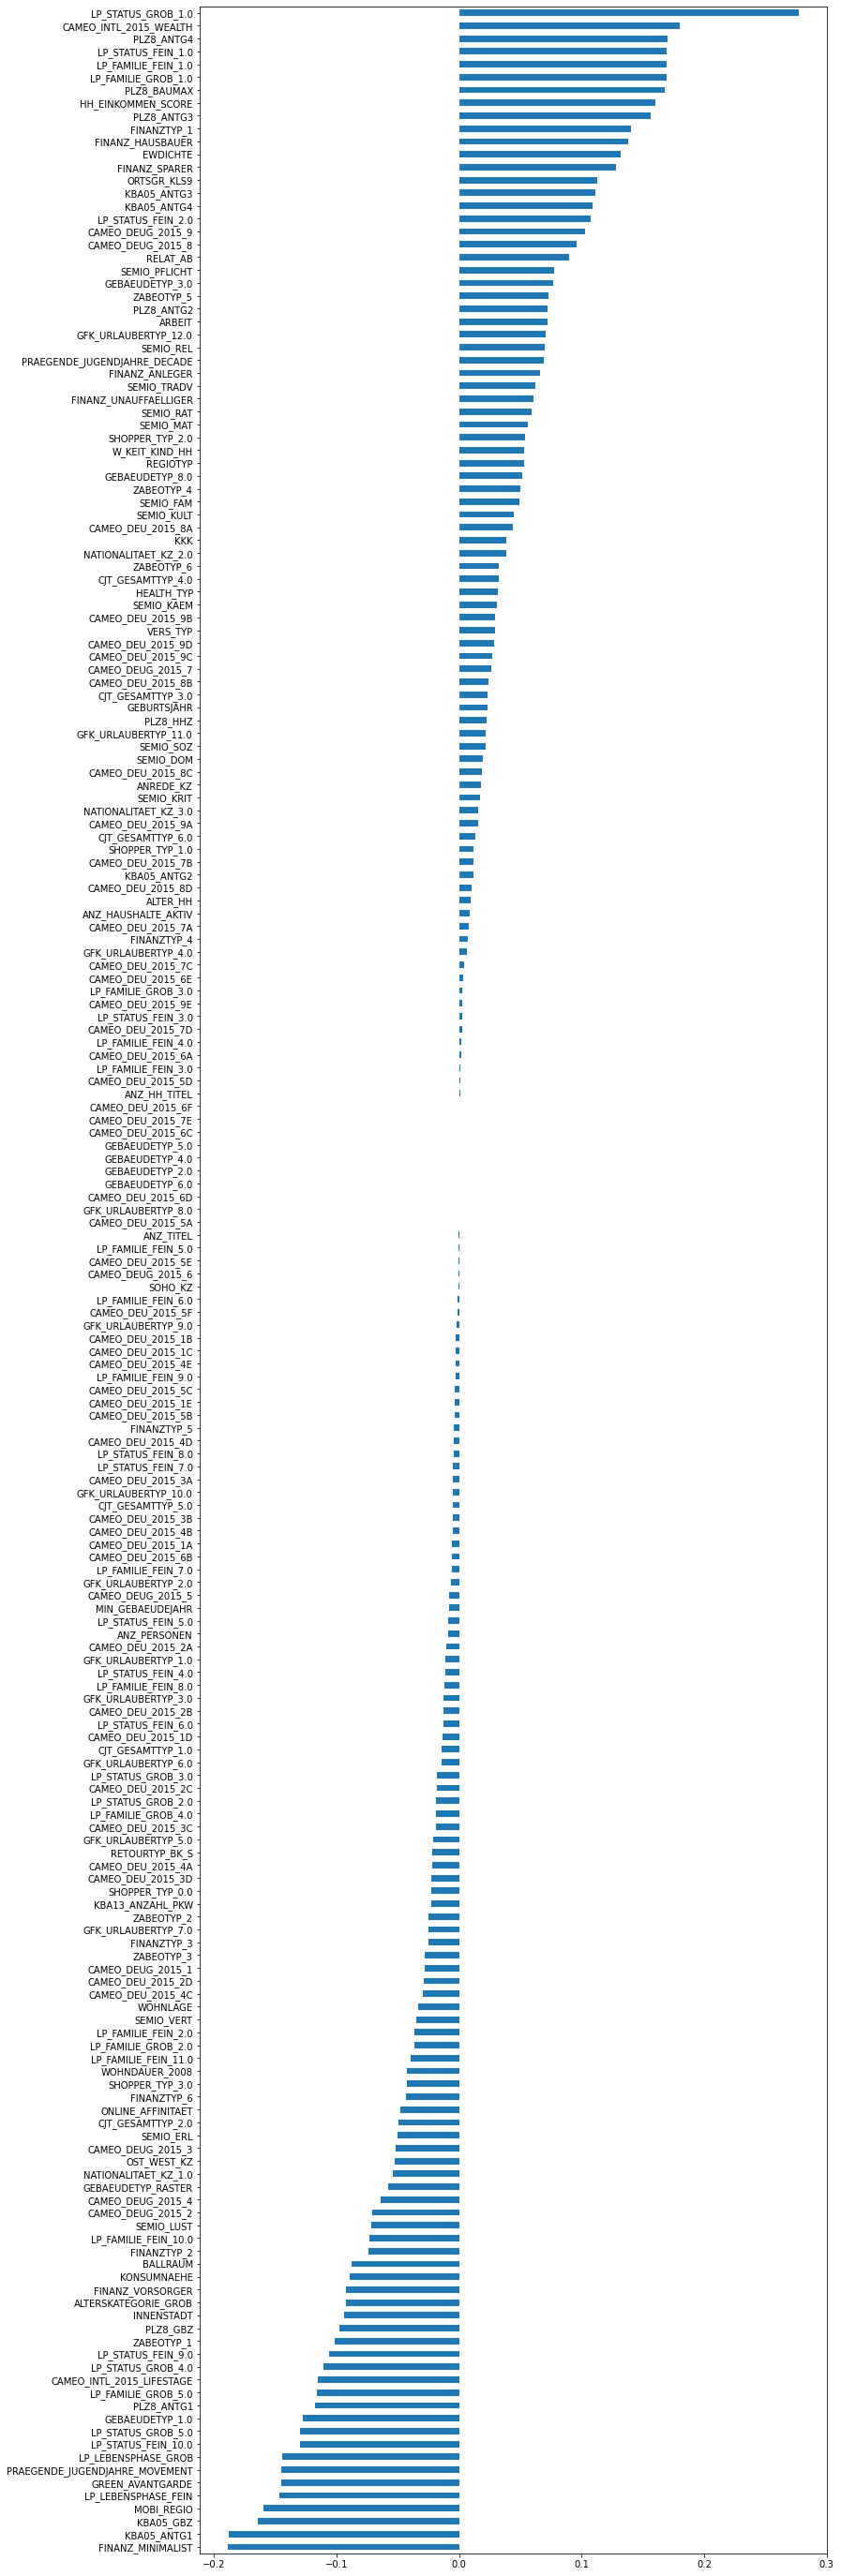

In [51]:

show_component(0, pca, one_hot_encoded_data_dropped)

In [52]:
# Save the most important categories for later use
important_components = ["LP_STATUS_GROB_1.0", "FINANZ_MINIMALIST", "KBA05_ANTG1"]

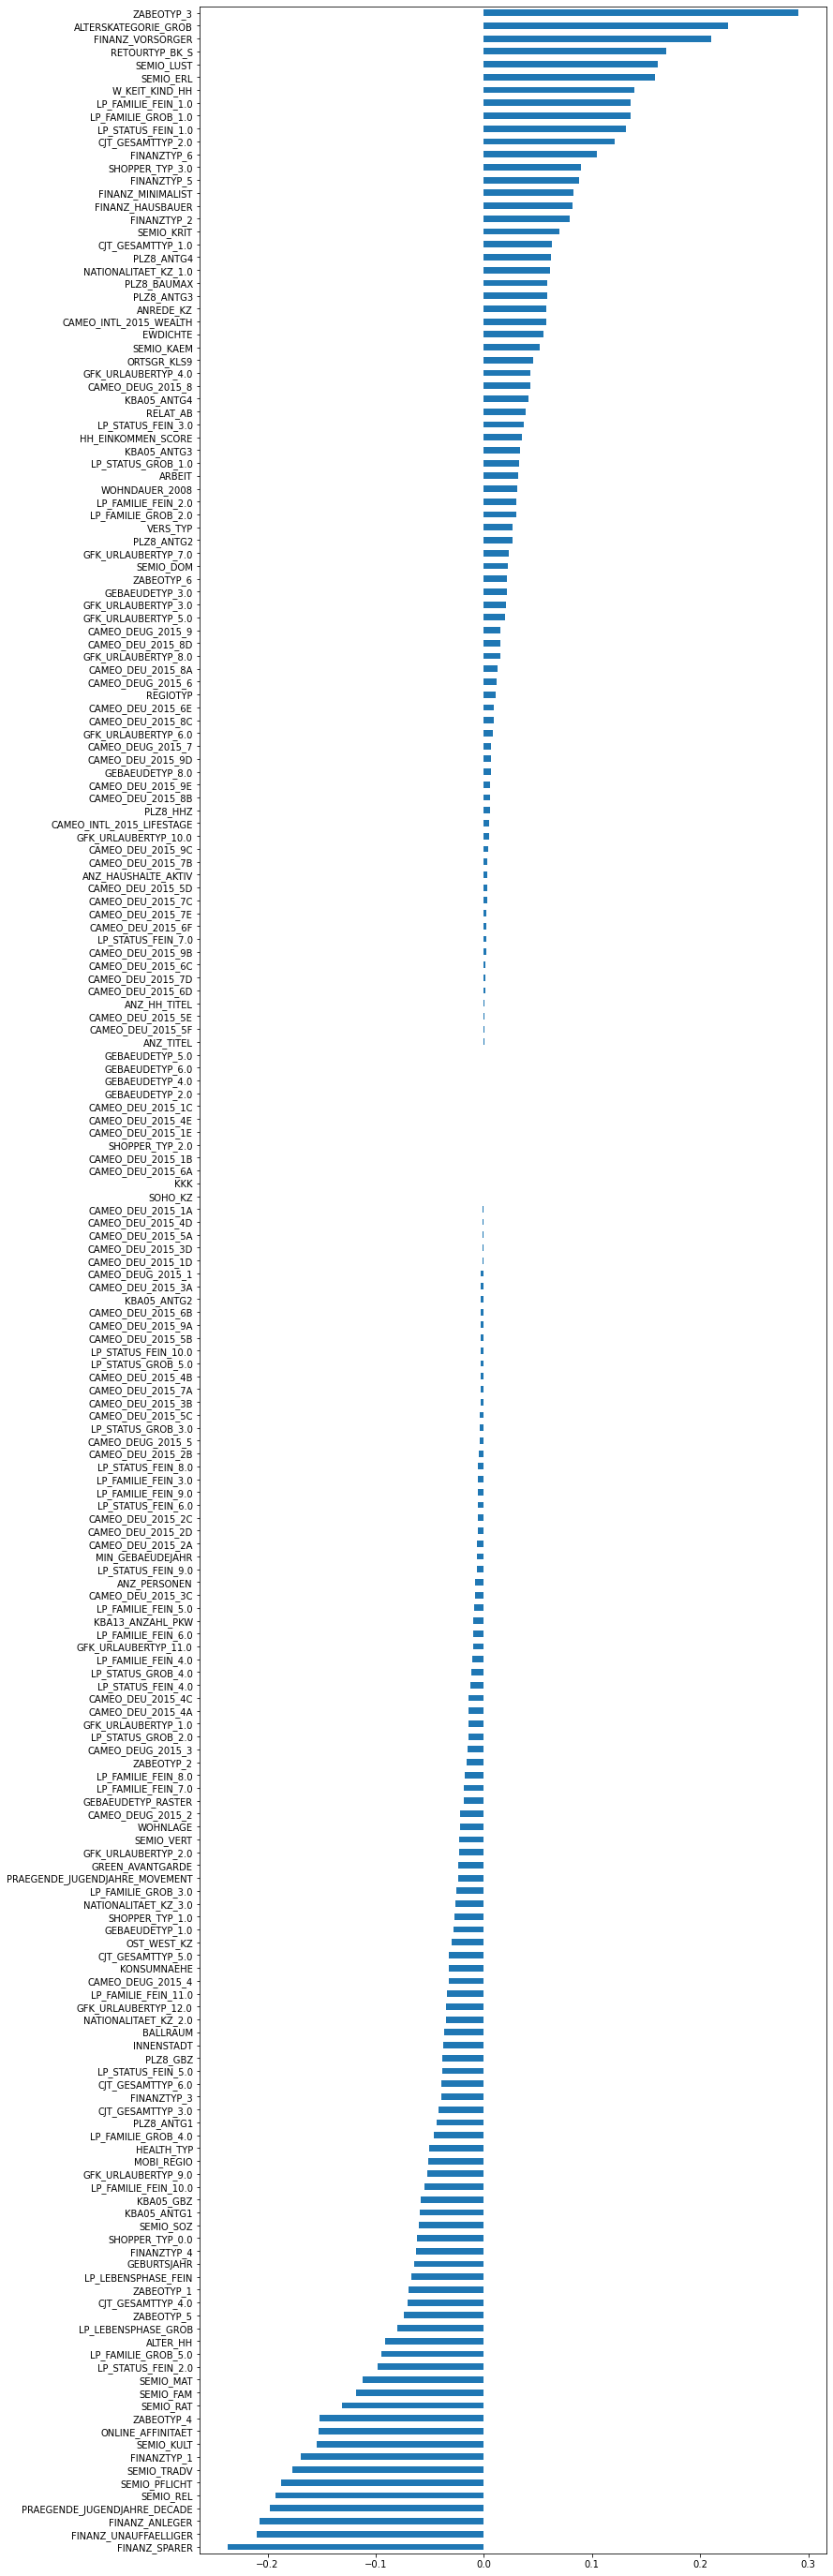

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_component(1, pca, one_hot_encoded_data_dropped)


In [54]:
important_components.extend(["ZABEOTYP_3", "ALTERSKATEGORIE_GROB", "FINANZ_SPARER"])

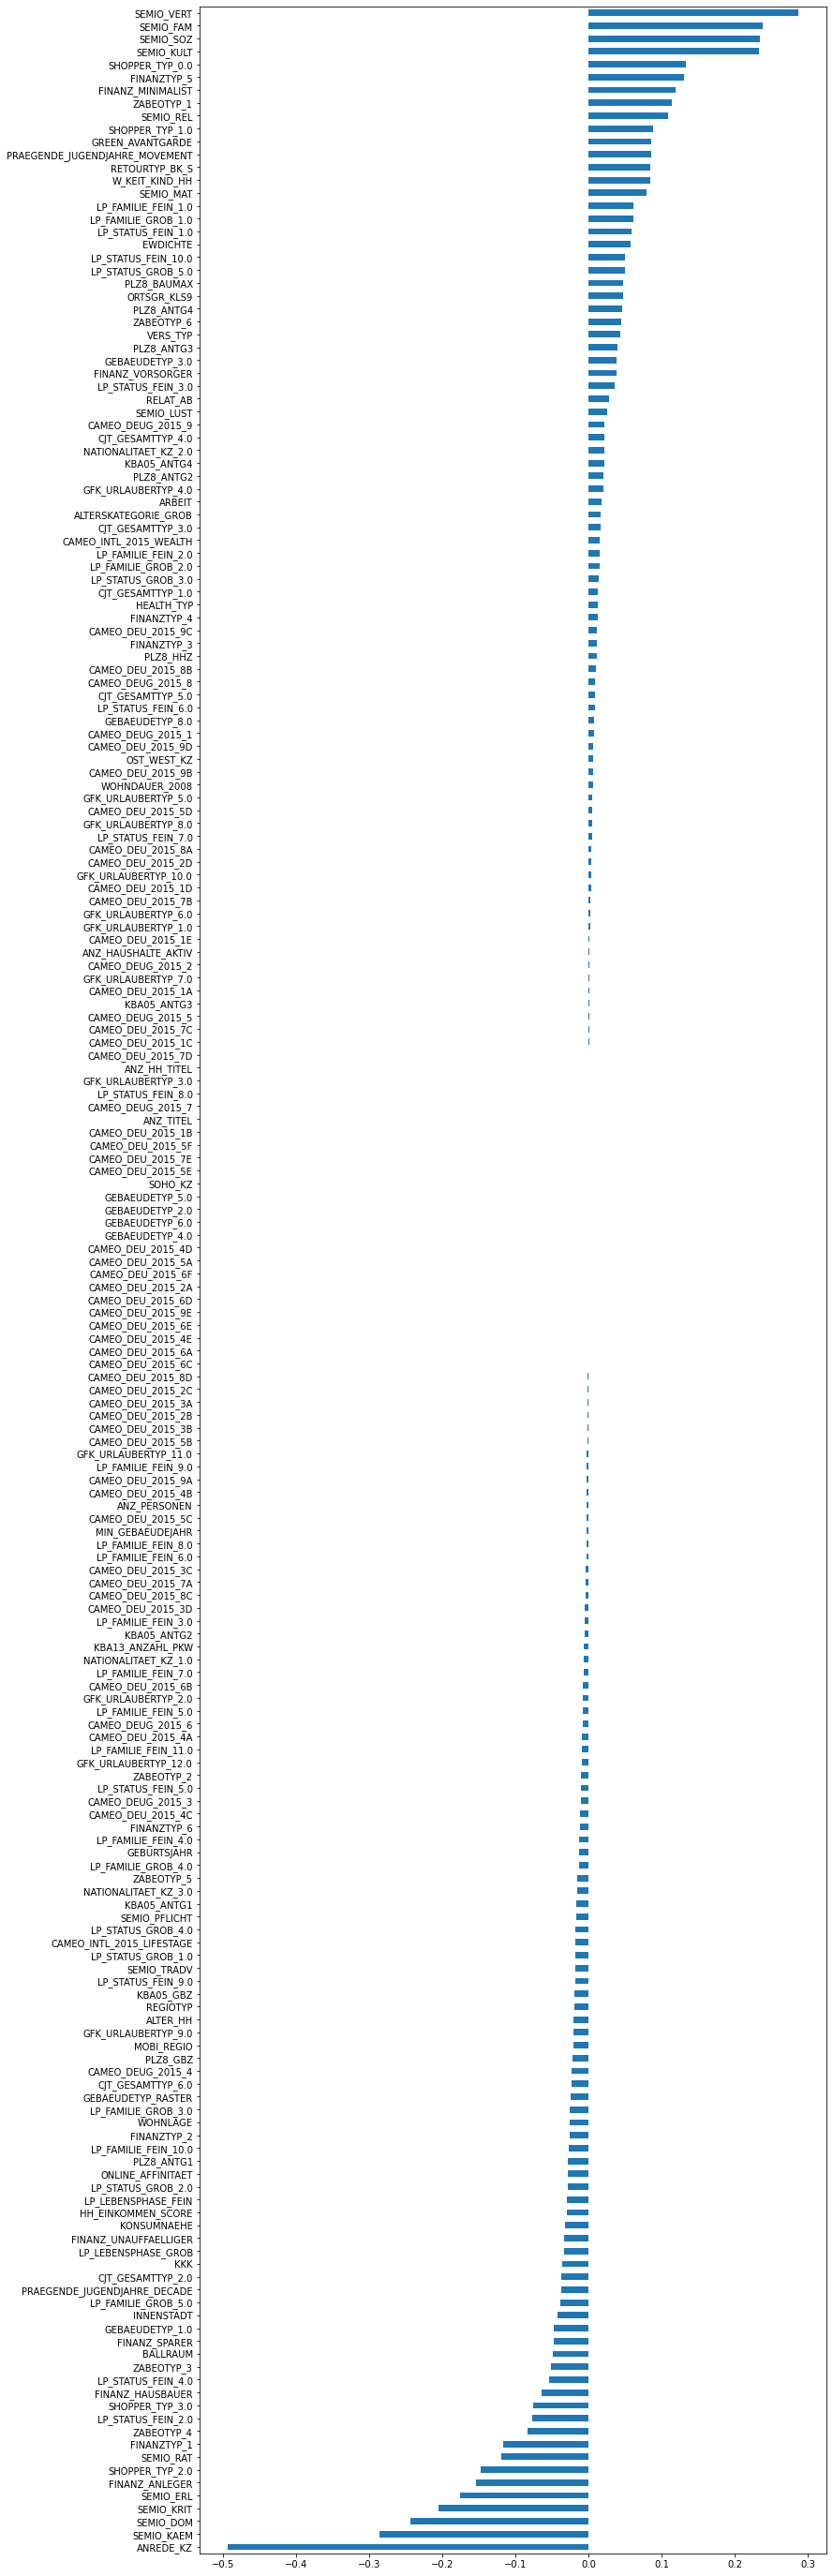

In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_component(2, pca, one_hot_encoded_data_dropped)

In [56]:
important_components.extend(["SEMIO_VERT", "ANREDE_KZ"])

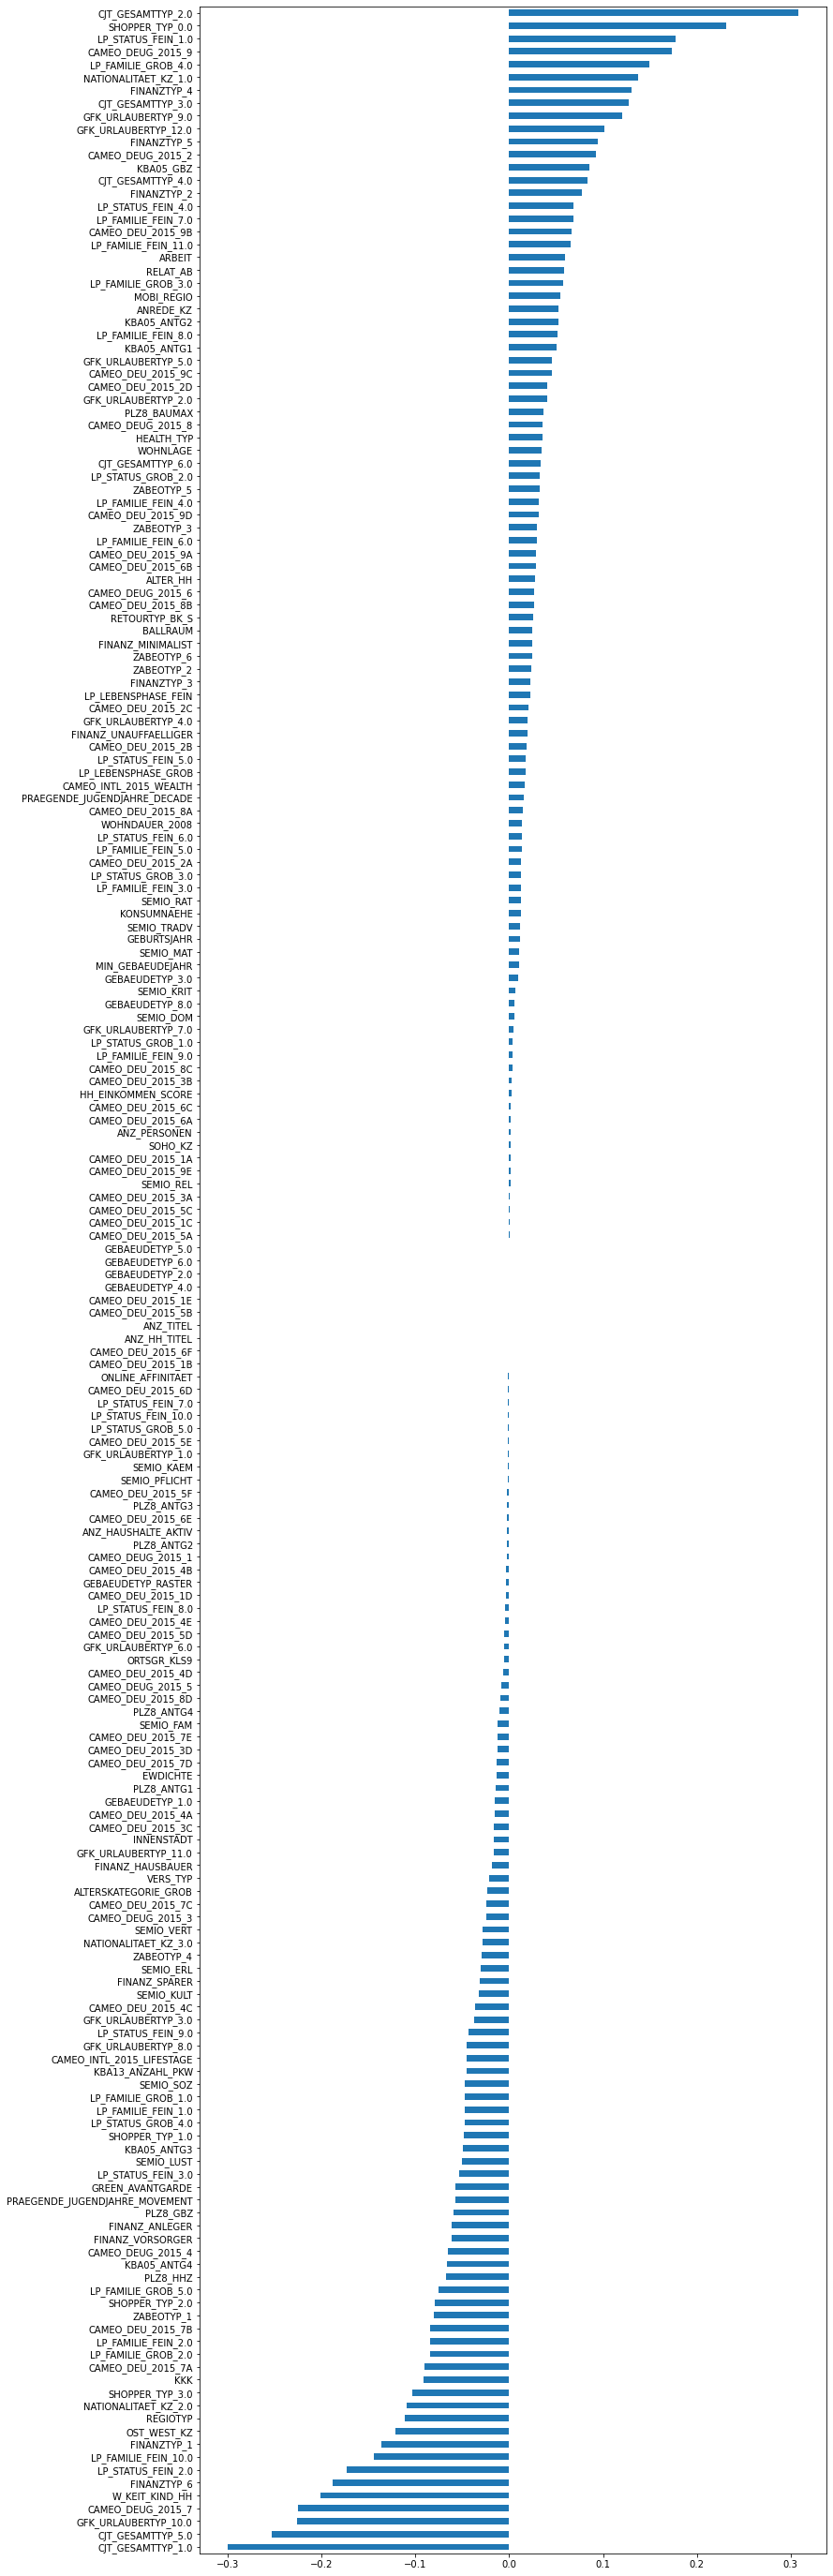

In [57]:
# curious about the least important component too
show_component(29, pca, one_hot_encoded_data_dropped)

### Discussion 2.3: Interpret Principal Components


We can see that the first component captures much information from many columns, while the next may capture more information from some columns, but not from as many as the first. The last column captures much information from one column, but far less from other columns.

It is also interesting to see that the columns at the positive and negative extremes are very different between the first components, which is the reason they separate much of the data from each other.

The positive and negative values indicates what columns that affects the component in opposite ways.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

data = X_pca

centers = list(range(1, 10))
scores = []
for center in centers:
    kmeans = KMeans(center, random_state = 99).fit(data)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.predict(data)
    
    score = 0
    for i in range(len(data)):
        center = centroids[clusters[i]]
        score += (data[i, 0] - center[0]) ** 2 + (data[i, 1] - center[1]) ** 2

    scores.append(score)
    

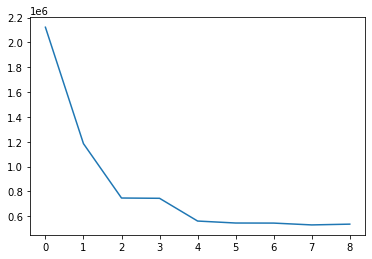

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(scores)


In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(4, random_state = 99).fit(data)
pop_clusters = kmeans.predict(data)

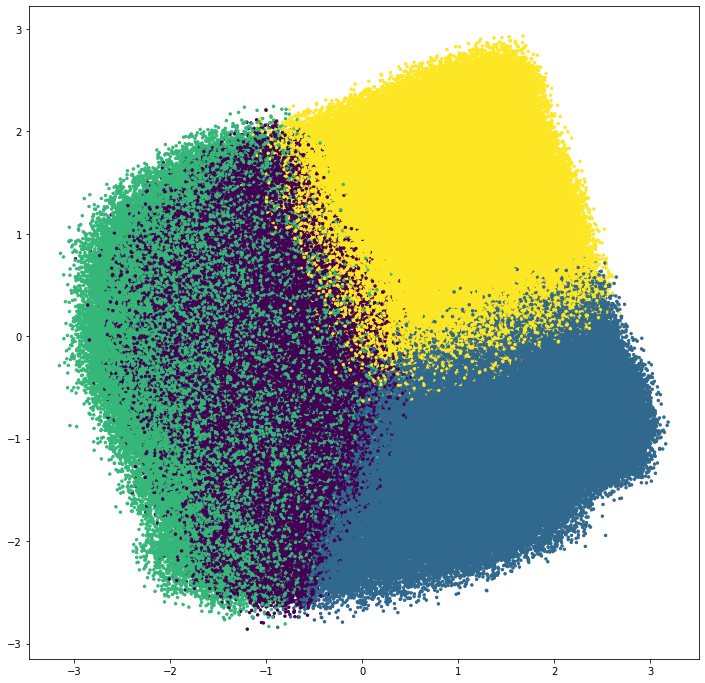

In [61]:
plt.figure(figsize=(12, 12))
plt.scatter(data[:, 0], data[:, 1], c=pop_clusters, s=6)

### Discussion 3.1: Apply Clustering to General Population


The elbow plot clearly shows 4 centroids, with nothing to gain using more.

The scatter map with 4 centroids is a bit hard to evaluate in 2 dimensions, but it seems to give pretty good separation.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')


In [63]:
# Clesan customer data
clean_customers = clean_data(customers)


In [64]:
# Add missing column(s) in customer data set with value 0
missing_columns = one_hot_encoded_data_dropped.columns.difference(clean_customers.columns)
clean_customers[missing_columns] = 0

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_dropped_na = clean_customers.dropna(axis = 0, subset = columns_with_few_na)
customers_with_imputer = imputer.transform(customers_dropped_na)
customers_scaled_data = scaler.transform(customers_with_imputer)


In [66]:
X_cust = pca.transform(customers_scaled_data)

In [67]:
cust_clusters = kmeans.predict(X_cust)

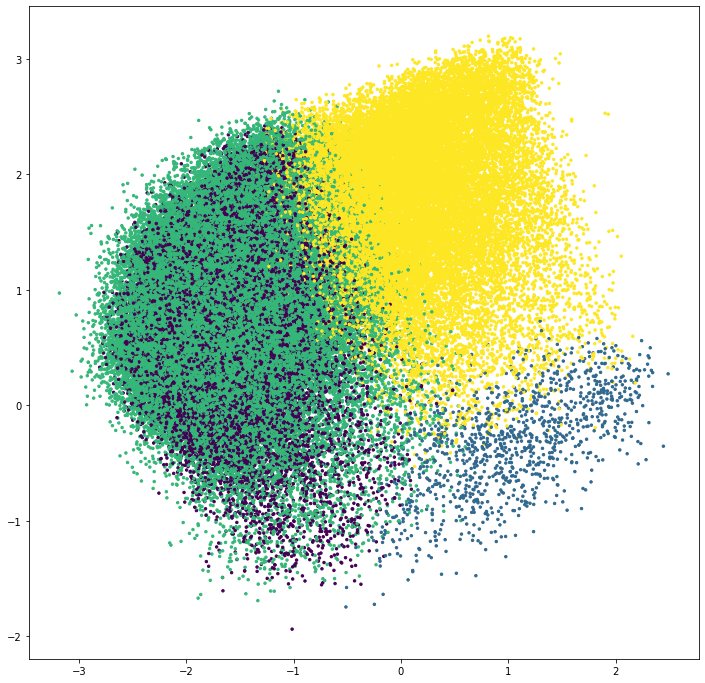

In [68]:
# Take a look
plt.figure(figsize=(12, 12))
plt.scatter(X_cust[:, 0], X_cust[:, 1], c=cust_clusters, s=6)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_cust = pd.DataFrame(cust_clusters)
sum_cust = df_cust.value_counts().sum()
percent_cust = df_cust.value_counts().sort_index() * 100 / sum_cust
percent_cust.name = "Customers"

df_pop = pd.DataFrame(pop_clusters)
sum_pop = df_pop.value_counts().sum()
percent_pop = df_pop.value_counts().sort_index() * 100 / sum_pop
percent_pop.name = "Population"

pd.DataFrame(cust_clusters).value_counts().sort_index()


0    23570
1     1115
2    68052
3    27119
dtype: int64

<AxesSubplot:xlabel='Cluster'>

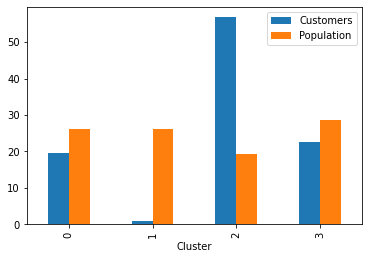

In [70]:
df_count = percent_cust.to_frame("Customers")
df_count = df_count.join(percent_pop.to_frame("Population"))
df_count["Cluster"] = list(range(df_count.shape[0]))
df_count.plot.bar(x = "Cluster")


In [71]:
df_count

,Customers,Population,Cluster
0,,,
0,19.665265,26.058459,0
1,0.930283,26.129773,1
2,56.778134,19.275411,2
3,22.626318,28.536357,3


In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 1 is over-represented in the customer data, while cluster 0 is under-represented

cluster_0 = kmeans.cluster_centers_[0]
cluster_1 = kmeans.cluster_centers_[1]

cluster_0_inv = pca.inverse_transform(cluster_0).reshape(1, -1)
cluster_1_inv = pca.inverse_transform(cluster_1).reshape(1, -1)



In [73]:
cluster_0_inv_sca = scaler.inverse_transform(cluster_0_inv)
cluster_1_inv_sca = scaler.inverse_transform(cluster_1_inv)

In [74]:
pd.options.display.float_format = '{:,.4f}'.format
overrep_features = pd.Series(data = cluster_1_inv_sca.flatten(), index = one_hot_encoded_data.columns)
pd.set_option("display.max_rows", None, "display.max_columns", None)
overrep_features

ALTERSKATEGORIE_GROB                 1.7099
ANREDE_KZ                            1.5673
FINANZ_MINIMALIST                    1.5110
FINANZ_SPARER                        4.4318
FINANZ_VORSORGER                     2.0602
FINANZ_ANLEGER                       4.1335
FINANZ_UNAUFFAELLIGER                3.9145
FINANZ_HAUSBAUER                     3.8307
GEBURTSJAHR                      1,978.4452
GREEN_AVANTGARDE                     0.0901
HEALTH_TYP                           2.2795
LP_LEBENSPHASE_FEIN                 10.3595
LP_LEBENSPHASE_GROB                  3.4118
RETOURTYP_BK_S                       2.4241
SEMIO_SOZ                            4.5999
SEMIO_FAM                            4.9702
SEMIO_REL                            5.5649
SEMIO_MAT                            4.8664
SEMIO_VERT                           3.8940
SEMIO_LUST                           2.8195
SEMIO_ERL                            3.3286
SEMIO_KULT                           5.2255
SEMIO_RAT                       

In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrep_features = pd.Series(data = cluster_0_inv_sca.flatten(), index = one_hot_encoded_data.columns)
pd.set_option("display.max_rows", None, "display.max_columns", None)
underrep_features

ALTERSKATEGORIE_GROB                 2.9935
ANREDE_KZ                            1.4940
FINANZ_MINIMALIST                    3.9550
FINANZ_SPARER                        2.2534
FINANZ_VORSORGER                     3.6593
FINANZ_ANLEGER                       2.9424
FINANZ_UNAUFFAELLIGER                2.2885
FINANZ_HAUSBAUER                     2.3656
GEBURTSJAHR                      1,964.9499
GREEN_AVANTGARDE                     0.0293
HEALTH_TYP                           2.2288
LP_LEBENSPHASE_FEIN                 21.2859
LP_LEBENSPHASE_GROB                  6.3700
RETOURTYP_BK_S                       3.3450
SEMIO_SOZ                            3.9611
SEMIO_FAM                            3.8395
SEMIO_REL                            3.6616
SEMIO_MAT                            3.5402
SEMIO_VERT                           4.3957
SEMIO_LUST                           4.4910
SEMIO_ERL                            4.8499
SEMIO_KULT                           4.0773
SEMIO_RAT                       

In [76]:
overrep_features.name = "over"
underrep_features.name = "under"
compare = pd.DataFrame([overrep_features, underrep_features]).T
compare["diff"] = compare["over"] - compare["under"]
compare["over"] = compare["over"] + 0


In [77]:

print("Most important categories:")
compare.loc[important_components]


Most important categories:


,over,under,diff
LP_STATUS_GROB_1.0,0.7679,0.0209,0.7470
FINANZ_MINIMALIST,1.5110,3.9550,-2.4440
KBA05_ANTG1,0.7647,2.4791,-1.7143
ZABEOTYP_3,0.0372,0.3628,-0.3256
ALTERSKATEGORIE_GROB,1.7099,2.9935,-1.2837
FINANZ_SPARER,4.4318,2.2534,2.1784
SEMIO_VERT,3.8940,4.3957,-0.5017
ANREDE_KZ,1.5673,1.4940,0.0733


### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 1 is clearly over-represented in the customer data, while cluster 0 is clearly under-represented.

From the most defining principal components, I have picked some of the most important categories. By looking at those categories in the data for over- and under-representation above, We can see what type of people that are more and less likely to become customers.

Here are the findings:

Column | More most likely to be customers | Less likely to be customer
:--- | :--- | :---
LP_STATUS_GROB_1 | High earners | Low earners
FINANZ_MINIMALIST | Low | High
KBA05_ANTG1 | High share of family homes | Low share of family homes
ZABEOTYP_3 | Fair supplied with energy | Price driven energy consumption
ALTERSKATEGORIE_GROB | 40-60 yeasrs old | Up to 35 years old
FINANZ_SPARER | High | Low
SEMIO_VERT | Lower affinity | Higher affinity
ANREDE_KZ | Slightly more male | Slightly more female



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.